In [23]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from data import *
from window import *
import matplotlib.pyplot as plt
import numpy as np

ticker = 'IESC'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)


[*********************100%%**********************]  1 of 1 completed


In [30]:
def backtest_strategy(data):
    """ Simulate trading based on provided buy and sell signals, including tracking entry and exit prices. """
    capital = 10000
    shares = 0
    short_shares = 0  # Track short positions separately
    #create portforlio dataframe 
    portfolio = pd.DataFrame(index=data.index, columns=['Portfolio Value', 'Entry Price', 'Stop Loss', 'Exit Price', 'Position Type'])
    entry_price = None
    stop_loss = None 
    exit_price = None
    prev_signal = None 
    in_position = False
    short_position = False

    for row_index in range(0, len(data)): 
        signal = generate_signals(data, row_index)
        current_price = data.iloc[row_index]['Close']
    
        if (signal == 'Buy' and not in_position) and (prev_signal != 'Buy' and capital > 0):  # Check if signal is 'Buy' and different from previous
            shares_to_buy = capital / current_price
            shares += shares_to_buy
            capital -= shares_to_buy * current_price
            entry_price = current_price
            fibonacci_levels = calculate_fibonacci_levels(data, row_index)
            stop_loss = update_stop_loss(current_price, fibonacci_levels)

            # Reset exit price when entering a new position
            exit_price = None
            in_position = True 
            portfolio.loc[data.index[row_index], 'Position Type'] = 'Long'

        if (prev_signal == 'Buy' and stop_loss is not None and current_price <= stop_loss) or (signal == 'Sell' and prev_signal != 'Sell' and shares > 0):
            capital += shares * current_price
            shares = 0
            exit_price = current_price
            # Reset entry price when exiting the position
            entry_price = None
            in_position = False
            portfolio.loc[data.index[row_index], 'Position Type'] = 'None'

        if (signal == 'Sell' and not short_position) and (prev_signal != 'Sell' and not in_position):  # Check if signal is 'Sell' and different from previous
            shares_to_short = capital / current_price
            short_shares += shares_to_short
            capital += short_shares * current_price
            entry_price = current_price
            fibonacci_levels = calculate_fibonacci_levels(data, row_index)
            stop_loss = update_stop_loss(current_price, fibonacci_levels)

            # Reset exit price when entering a new position
            exit_price = None
            short_position = True 
            portfolio.loc[data.index[row_index], 'Position Type'] = 'Short'

        if (prev_signal == 'Sell' and stop_loss is not None and short_position) and (current_price >= stop_loss) or (signal == 'Buy' and prev_signal != 'Buy' and short_shares > 0):
            capital -= short_shares * current_price
            short_shares = 0
            exit_price = current_price
            # Reset entry price when exiting the position
            entry_price = None
            stop_loss = None
            short_shares = 0
            portfolio.loc[data.index[row_index], 'Position Type'] = 'None'

        # Calculate portfolio value
        portfolio_value = capital + (shares * current_price) - (short_shares * current_price)
        portfolio.loc[data.index[row_index], 'Entry Price'] = entry_price
        portfolio.loc[data.index[row_index], 'Stop Loss'] = stop_loss
        portfolio.loc[data.index[row_index], 'Portfolio Value'] = portfolio_value
        portfolio.loc[data.index[row_index], 'Exit Price'] = exit_price
        
        prev_signal = signal  # Update previous signal for next iteration

    return portfolio.fillna(0)


def calculate_performance(portfolio):
    """ Calculate the percent change in portfolio value from the first day to the last. """
    first_day_value = portfolio.iloc[0]['Portfolio Value']
    last_day_value = portfolio.iloc[-1]['Portfolio Value']
    percent_change = ((last_day_value - first_day_value) / first_day_value) * 100
    return percent_change


# Running the backtest
tickers = ['SPY', 'NDAQ','JPM', 'C', 'BAC', 'PANW', 'SHOP', 'NET', 'TSM', 'CRM', 'ON', 'SONY', 'CRWD', 'AMAT', 'AMZN', 'AAPL']

for ticker in tickers: 
    data = fetch_data(ticker, start_date, end_date)
    portfolio = backtest_strategy(data)
    performance = calculate_performance(portfolio)
    print(f"Performance of {ticker} is {performance:.2f}%")

# Display results
print(portfolio)

[*********************100%%**********************]  1 of 1 completed
Performance of SPY is 2.47%
[*********************100%%**********************]  1 of 1 completed
Performance of NDAQ is -7.55%
[*********************100%%**********************]  1 of 1 completed
Performance of JPM is 11.74%
[*********************100%%**********************]  1 of 1 completed
Performance of C is 7.43%
[*********************100%%**********************]  1 of 1 completed
Performance of BAC is 5.86%
[*********************100%%**********************]  1 of 1 completed
Performance of PANW is 0.89%
[*********************100%%**********************]  1 of 1 completed
Performance of SHOP is 1.44%
[*********************100%%**********************]  1 of 1 completed
Performance of NET is -19.52%
[*********************100%%**********************]  1 of 1 completed
Performance of TSM is -1.22%
[*********************100%%**********************]  1 of 1 completed
Performance of CRM is -5.34%
[*********************1

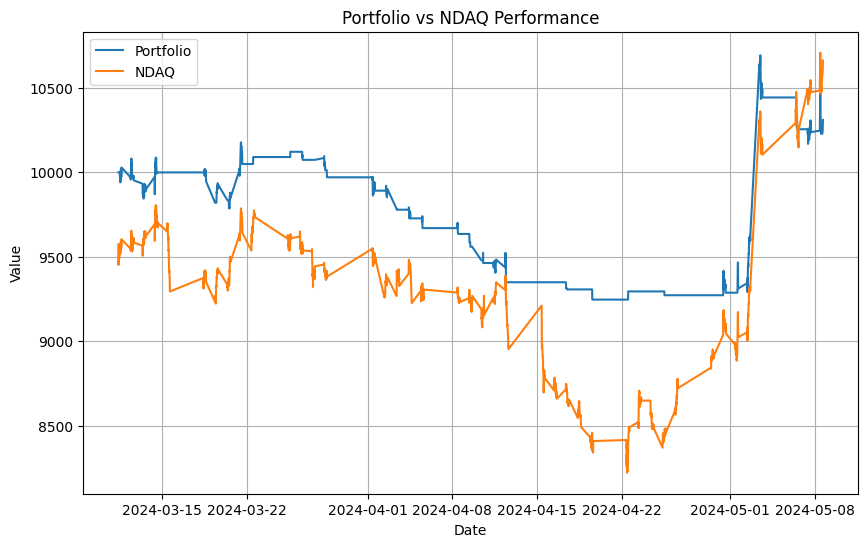

In [73]:
Ndaq_data = data['Close']*6.2

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(Ndaq_data.index, Ndaq_data, label='NDAQ')
plt.title('Portfolio vs NDAQ Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Already tried NDAQ (underperform), AAPL (Underperform)

In [31]:
ticker = 'TSLA'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

portfolio = backtest_strategy(data)

[*********************100%%**********************]  1 of 1 completed


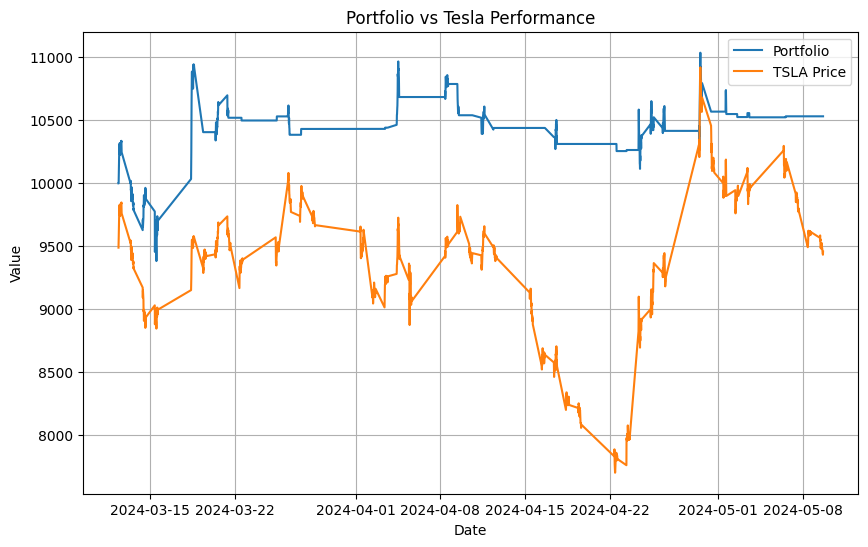

In [32]:
stock_data = data['Close']*55

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(stock_data.index, stock_data, label='TSLA Price')
plt.title('Portfolio vs Tesla Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
ticker = 'SPY'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

portfolio = backtest_strategy(data)

[*********************100%%**********************]  1 of 1 completed


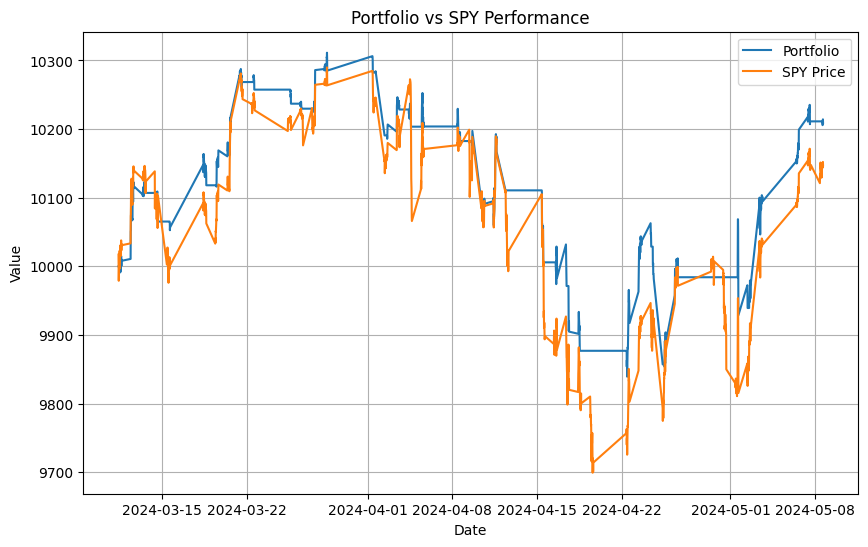

In [14]:
stock_data = data['Close']*19.62

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(stock_data.index, stock_data, label='SPY Price')
plt.title('Portfolio vs SPY Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed


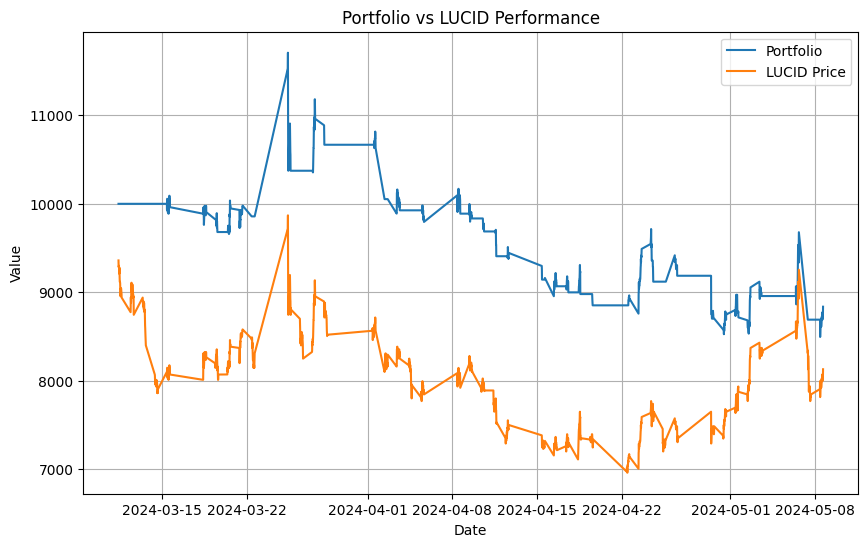

In [15]:
ticker = 'LCID'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

stock_data = data['Close']*3000

portfolio = backtest_strategy(data)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(stock_data.index, stock_data, label='LUCID Price')
plt.title('Portfolio vs LUCID Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed


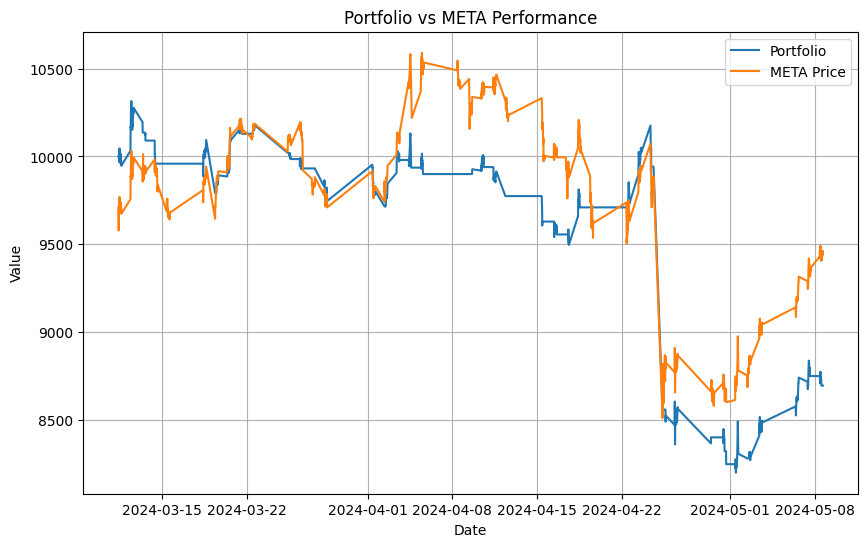

In [16]:
ticker = 'META'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

stock_data = data['Close']*20

portfolio = backtest_strategy(data)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(stock_data.index, stock_data, label='META Price')
plt.title('Portfolio vs META Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed


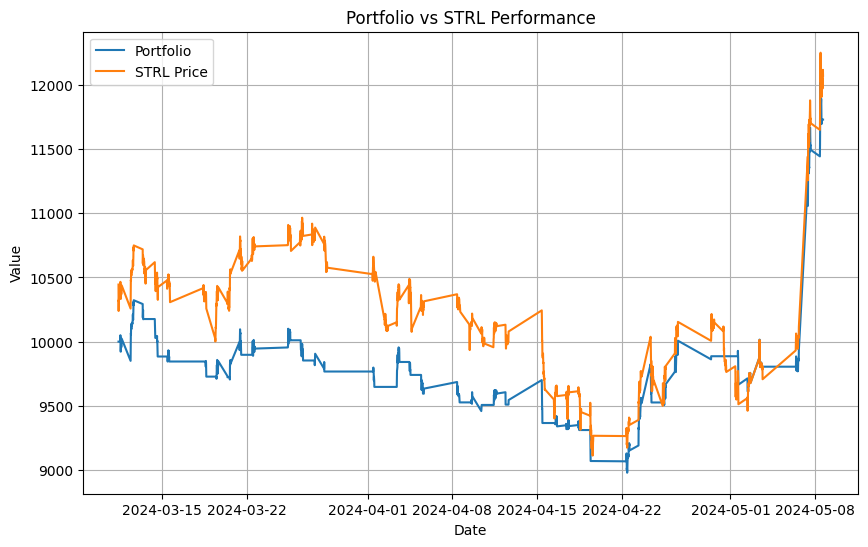

In [20]:
ticker = 'STRL'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

stock_data = data['Close']*96

portfolio = backtest_strategy(data)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(stock_data.index, stock_data, label='STRL Price')
plt.title('Portfolio vs STRL Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()